# Description

In this step, we need to preprocess our data based on the EDA.

It includes:
- loading the data.
- train-test split.
- applying a one-hot encoder on the categorical column.
- applying normalization on the numerical columns.
- applying SMOTEEN (a method that combines oversampling and undersampling).
- saving the preprocessed data.

# Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN

plt.close("all")
plt.style.use('ggplot')

In [2]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load data

In [3]:
# Load data 

df = pd.read_csv('../data/loan_prediction.csv')

In [4]:
# Check first rows of the data

df.head()

,Age,Income,Credit_Score,Loan_Amount,Loan_Term,Employment_Status,Loan_Approved
0,56,81788,334,15022,48,Employed,0
1,69,102879,781,21013,24,Self-Employed,1
2,46,58827,779,39687,60,Self-Employed,0
3,32,127188,364,16886,24,Unemployed,0
4,60,25655,307,26256,36,Unemployed,0


# Train test split

In [5]:
# Split the data into X (all features without the target) and y (the target attribute).

X = df[['Age', 'Income', 'Credit_Score', 'Loan_Amount',	'Loan_Term', 'Employment_Status']]
y = df['Loan_Approved']

In [6]:
# Split the data into train and test parts (test_size = 30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Data preprocessing

Create a column transformer to preprocess the data. For numerical columns, we use normalization with range (0, 1), and for the categorical column, we use a one-hot encoder. Then apply it to our data and check the results.

In [7]:
# Define numerical columns and categorical column

numerical_features = ['Age', 'Income', 'Credit_Score', 'Loan_Amount', 'Loan_Term']
categorical_features = ['Employment_Status']

In [8]:
# Create preprocessing pipelines for numerical and categorical columns

numerical_preprocessing = Pipeline( steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
] )

categorical_preprocessing = Pipeline( steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
] )


In [9]:
# Create a column transformer that outputs a preprocessed pandas DataFrame

column_transformer = ColumnTransformer( transformers=[
    ('num', numerical_preprocessing, numerical_features),
    ('cat', categorical_preprocessing, categorical_features)
])

column_transformer.set_output(transform='pandas')

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Age', 'Income', 'Credit_Score',
                                  'Loan_Amount', 'Loan_Term']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Employment_Status'])])

In [10]:
# Transform the data

X_train = column_transformer.fit_transform(X_train)
X_test= column_transformer.transform(X_test)

In [11]:
# Check the transformed data

X_train.head()

,num__Age,num__Income,num__Credit_Score,num__Loan_Amount,num__Loan_Term,cat__Employment_Status_Employed,cat__Employment_Status_Self-Employed,cat__Employment_Status_Unemployed
243,0.058824,0.087849,0.265938,0.996686,0.75,1.0,0.0,0.0
1151,0.254902,0.457535,0.908925,0.430667,0.50,0.0,1.0,0.0
1892,0.647059,0.114621,0.615665,0.753069,0.25,0.0,1.0,0.0
410,0.509804,0.279828,0.550091,0.748016,0.75,1.0,0.0,0.0
1449,0.372549,0.644385,0.009107,0.306465,0.25,1.0,0.0,0.0


In [12]:
# Save the column transformer

joblib.dump(column_transformer, '../models/transformer.joblib')

['../models/transformer.joblib']

# Smoteen

Based on the EDA, we know that the data has a class imbalance, so we need to do something to fix it. We will use SMOTEEN, a method that combines oversampling and undersampling. We will apply this only to the train part

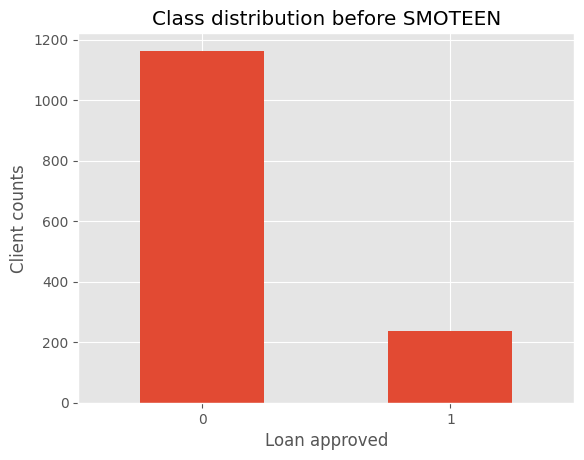

In [23]:
# Check the class distribution before applying SMOTEEN

class_distrbtn = y_train.value_counts()

class_distrbtn.plot.bar(ylabel='Client counts', xlabel='Loan approved', title='Class distribution before SMOTEEN')
plt.xticks(rotation=0)
plt.show()

In [16]:
# Create and apply SMOTEEN

smoot_enn = SMOTEENN(random_state=11)
X_train_resampled, y_train_resampled = smoot_enn.fit_resample(X_train, y_train)

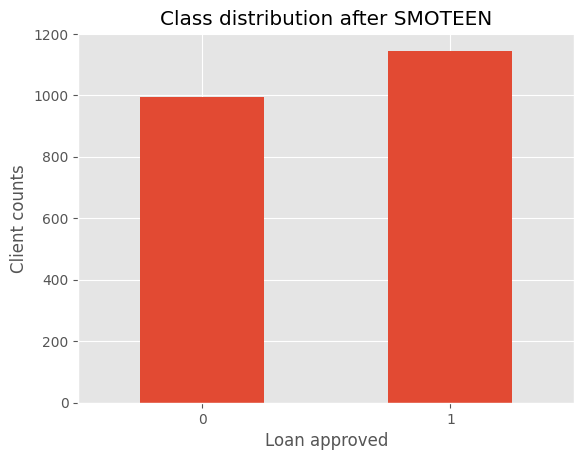

In [24]:
# Check the class distribution after applying SMOTEEN

class_distrbtn_smoteen = y_train_resampled.value_counts(sort=False)

class_distrbtn_smoteen.plot.bar(ylabel='Client counts', xlabel='Loan approved', title='Class distribution after SMOTEEN')
plt.xticks(rotation=0)
plt.show()

# Save preprocessed data

We save the preprocessed data to use them later for training and testing models.

In [15]:
# Concatenate and save the train part of the data

train = pd.concat([X_train_resampled, y_train_resampled], axis=1)
train.to_csv('../data/processed/train.csv', index=False)

In [16]:
# Concatenate and save the test part of the data

test = pd.concat([X_test, y_test], axis=1)
test.to_csv('../data/processed/test.csv', index=False)